# Notebook about Motor Vehicle Collisions in New York City

In [27]:
import pandas as pd
import time
import numpy as np
import calendar
import plotly.express as px

t1 = time.time()
df = pd.read_csv('Motor_Vehicle_Collisions_Crashes.csv')
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")
t2 = time.time()

#Discard 2012 and 2021. 
df = df.loc[(df['TIME'].dt.year > 2012) & (df['TIME'].dt.year < 2021)]

print(f'Time elapsed: {t2-t1} seconds.')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time elapsed: 13.247107028961182 seconds.


# Probability of being injured or killed

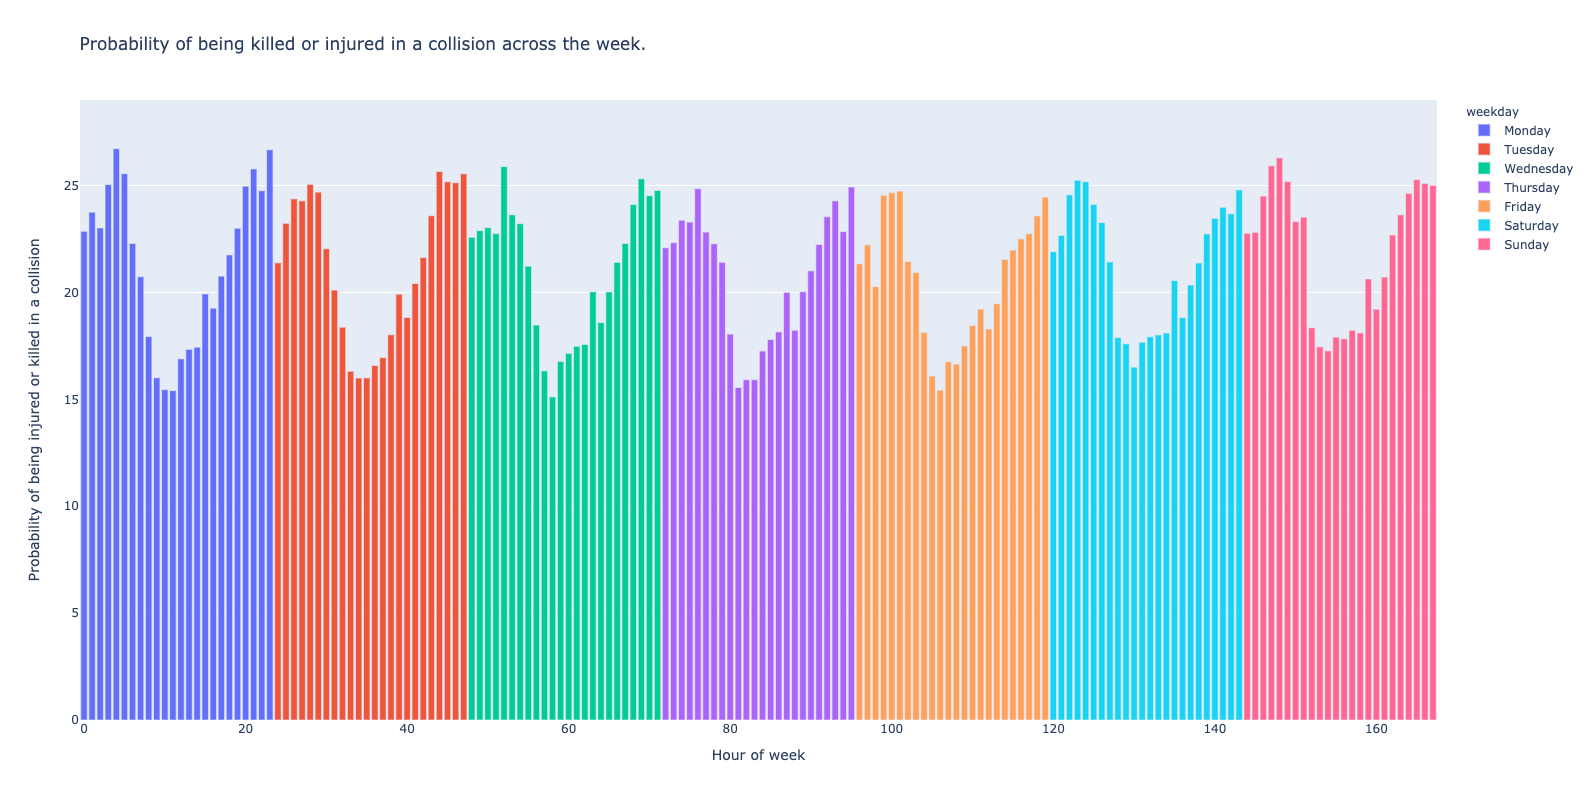

In [30]:
df['AnyInjured'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)
df['AnyKilled']  = (df['NUMBER OF PERSONS KILLED'] > 0).astype(int)

df_plot1 = pd.DataFrame({'hour_of_week'          : np.arange(0,24*7),
                         'only_injured'  : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 0)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'only_killed'   : df.loc[(df['AnyInjured'] == 0)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'both'          : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'either'        : df.loc[(df['AnyInjured'] == 1)|(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'total_count'   : df.groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().values.reshape(-1,order='F'),
                         'weekday'       : np.repeat(list(calendar.day_name),24)})

df_plot1['probability'] = (df_plot1['either']/df_plot1['total_count'])*100
df_plot1['weekday_and_time'] = df_plot1['weekday'] + ' ' + [str(x).zfill(2)+':00' for x in np.arange(0,24)]*7

fig = px.bar(df_plot1,x='hour_of_week', y='probability',
             custom_data=['only_injured', 'only_killed', 'both', 'total_count', 'weekday_and_time'],
             labels = {'hour_of_week' : 'Hour of week', 'probability' : 'Probability of being injured or killed in a collision'},
             color='weekday',
             title='Probability of a collision being either deadly or serious across the week.',
             height=800, width=1500)


fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[4]}</b>",
        "",
        "Number of collisions with only injured: %{customdata[0]}",
        "Number of collisions with only killed: %{customdata[1]}",
        "Number of collisions with both killed and injured: %{customdata[2]}",
        "Total number of collisions: %{customdata[3]}",
        "",
        "Probability of a collision being serious: %{y}%",
    ])
)

fig.update_layout(yaxis_range=[0,np.ceil(df_plot1['probability'].max())+2])
fig.show()

In [106]:
import numpy as np
factors = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,)
factors = np.unique(factors[~pd.isna(factors)])

In [126]:
mask = np.zeros(len(df))
contributing_factors = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values
for factor in factors:
    for i in range(len(df)):
        if factor in contributing_factors[i,:]:
            mask[i] = 1
            
    df_subset = df.iloc[mask.astype(bool),:]
    
    p = len(df_subset.loc[(df_subset['NUMBER OF PERSONS KILLED'] + df_subset['NUMBER OF PERSONS INJURED']) > 0]) / len(df_subset)
    print(f'{factor} : {p}')

1 : 0.21428571428571427
80 : 0.18487394957983194
Accelerator Defective : 0.2849846782431052
Aggressive Driving/Road Rage : 0.28625014652444025
Alcohol Involvement : 0.29801968641792786
Animals Action : 0.29108764128219383
Backing Unsafely : 0.1457545942006351
Brakes Defective : 0.15415875389898553
Cell Phone (hand-Held) : 0.1548124124281053
Cell Phone (hand-held) : 0.15487938596491227
Cell Phone (hands-free) : 0.15500605492402048
Driver Inattention/Distraction : 0.1994683019175551
Driver Inexperience : 0.1986347289485014
Driverless/Runaway Vehicle : 0.19852977326701138
Drugs (Illegal) : 0.19862541193858352
Drugs (illegal) : 0.19897015628966166
Eating or Drinking : 0.19898061461687744
Failure to Keep Right : 0.19907682134924806
Failure to Yield Right-of-Way : 0.22394303063836643
Fatigued/Drowsy : 0.22038069033623478
Fell Asleep : 0.22099804946202906
Following Too Closely : 0.22163166234595205
Glare : 0.2224511573996679
Headlights Defective : 0.22246521151676393
Illnes : 0.22315297861361

## Cleaning up the data

In [3]:
df_serious = df.loc[(df['NUMBER OF PERSONS KILLED'] + df['NUMBER OF PERSONS INJURED']) > 0]
df_serious['TIME'] = pd.to_datetime(df_serious['CRASH DATE'] + ' ' + df_serious['CRASH TIME']) #Takes approximately 1 minute.

#Discard 2012 and 2021.
df_serious = df_serious.loc[~((df_serious['TIME'].dt.year == 2012) | (df_serious['TIME'].dt.year == 2021))]


#Drop rows with NA in BOROUGH, ZIP CODE, LATITUDE or LONGITUDE.
#col = ['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE']
#for c in col:
#    df_serious = df_serious.loc[~pd.isna(df_serious[c])]
#    
#Drop rows where LAT, LON == 0.000
#df_serious = df_serious.loc[~(df_serious['LATITUDE'] == 0)]
#df_serious = df_serious.loc[~(df_serious['LONGITUDE'] == 0)]

KeyboardInterrupt: 

Print the first observations.

# General Properties (Time)

TIME does not contain any NANs.

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.year).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.month).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.weekday).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.hour).size()

# General Properties (BOROUGH and ZIP CODE)


In [ ]:
df_serious.groupby(df_serious['BOROUGH']).size()

In [ ]:
df_serious.groupby(df_serious['ZIP CODE']).size()

# General Properties (Vehicle Types)

In [ ]:
replace_vehicle = dict(zip(pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/vehicle_types.csv?token=AINZZODWKIOWT5UAXKP6RWLAR2E3U', sep=';')['Specific'].to_numpy(),
                           pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/vehicle_types.csv?token=AINZZODWKIOWT5UAXKP6RWLAR2E3U', sep=';')['General'].to_numpy()))

replace_factor  = dict(zip(pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/contributing_factors.csv?token=AINZZOCQQESHJCRAPW23KEDAR2GYI', sep=';')['Specific'].to_numpy(),
                           pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/contributing_factors.csv?token=AINZZOCQQESHJCRAPW23KEDAR2GYI', sep=';')['General'].to_numpy()))

for i in range(1, 6): 
    print(f'Processing VEHICLE {i}.')
    df_serious[f'VEHICLE TYPE CODE {i} (AGGR)'] = df_serious[f'VEHICLE TYPE CODE {i}'].str.lower().fillna(' ').replace(replace_vehicle)
    df_serious[f'CONTRIBUTING FACTOR VEHICLE {i} (AGGR)'] = df_serious[f'CONTRIBUTING FACTOR VEHICLE {i}'].fillna(' ').replace(replace_factor)
    print(f'Processed VEHICLE {i}.')

In [ ]:
df_serious[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]]['CONTRIBUTING FACTOR VEHICLE 1'].fillna(' ').unique()